## Imports

In [1]:
from pathlib import Path
import sys

# Add repo root and code/ to sys.path
repo_root = Path.cwd().parents[1]
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / "code"))

from utils import helper_functions as hf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.registration import phase_cross_correlation
import os
import importlib
import torch
import torch.nn.functional as F
from scipy import signal
import cv2
from IPython import get_ipython
from IPython.display import display
import matplotlib
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Rectangle
from matplotlib import animation


---
### load subjects and plot raw fUS activity of their first session over time with label shading (blue = baseline)

Subject: secundo
  data_directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo
  data_output_dir: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo
  - MISMATCH: Images=7500, Labels=8109. Shaving to 7500 frames.


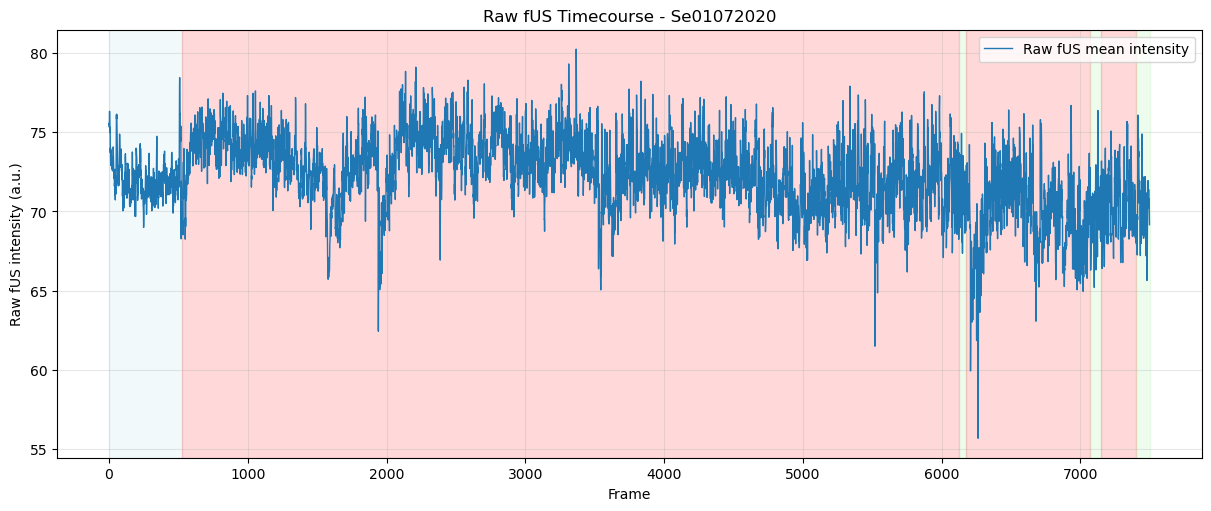

Subject: gus
  data_directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\gus
  data_output_dir: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus
  - MISMATCH: Images=8000, Labels=9198. Shaving to 8000 frames.


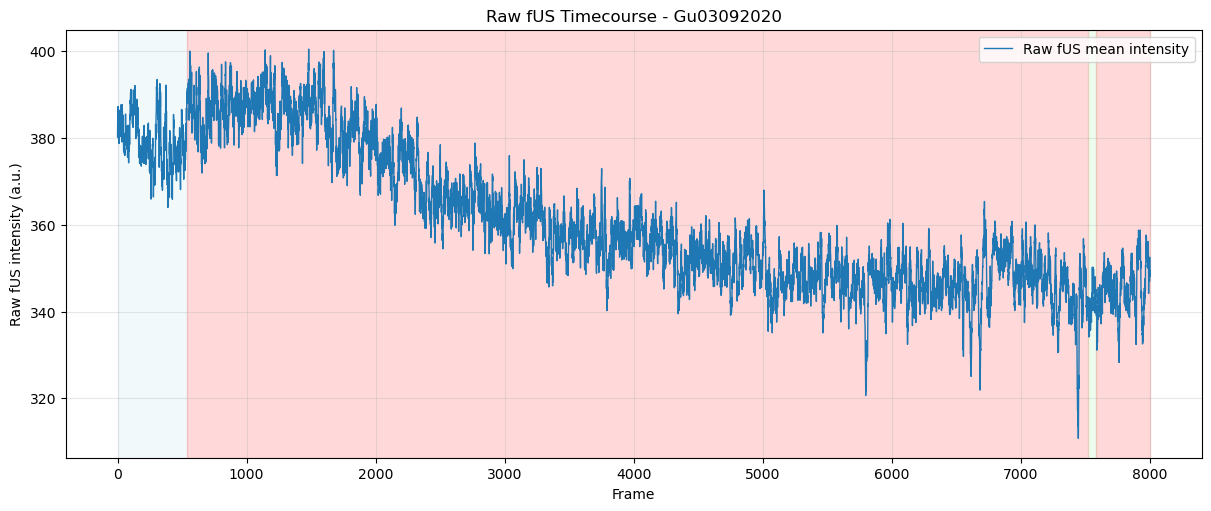

In [2]:
hf = importlib.reload(hf)

subjects = ["secundo", "gus"]

repo_root = Path(r"C:\Users\ESPCI\Documents\GitHub\fUSPredict")
source_root = repo_root / "sourcedata"
deriv_root = repo_root / "derivatives" / "preprocessing"

for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)

    print(f"Subject: {subject}")
    print(f"  data_directory: {data_directory}")
    print(f"  data_output_dir: {data_output_dir}")

    hf.plot_fus_timecourse_with_labels(
        str(data_directory),
        sessions="first"
    )


---
### Extract and Save Baseline Frames

Extract baseline frames (blue shading above, label == -1) from all sessions and save as per-session .npz files.

In [3]:
# Set up output directory for baseline files
for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    print(f"Baseline output directory: {baseline_output_dir}")

    # Process all files for that subject and save baseline files
    baseline_files = hf.process_all_baseline_files(data_directory, baseline_output_dir)

Baseline output directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\baseline_only
Found 34 fUS files to process

⏭️  Skipping Se01072020 (already exists)
⏭️  Skipping Se01092020 (already exists)
⏭️  Skipping Se01102020 (already exists)
⏭️  Skipping Se01122020 (already exists)
⏭️  Skipping Se02122020 (already exists)
⏭️  Skipping Se03022020 (already exists)
⏭️  Skipping Se03092020 (already exists)
⏭️  Skipping Se04022020 (already exists)
⏭️  Skipping Se04032020 (already exists)
⏭️  Skipping Se04062021 (already exists)
⏭️  Skipping Se04082020 (already exists)
⏭️  Skipping Se04092020 (already exists)
⏭️  Skipping Se05022020 (already exists)
⏭️  Skipping Se05082020 (already exists)
⏭️  Skipping Se06012020 (already exists)
⏭️  Skipping Se22092020 (already exists)
⏭️  Skipping Se22102019 (already exists)
⏭️  Skipping Se22112019 (already exists)
⏭️  Skipping Se23072020 (already exists)
⏭️  Skipping Se24022020 (already exists)
⏭️  Skipping Se24062020 (alread

---
### Load Baseline Data

Load baseline sessions for model training.

In [4]:
for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    # Load all baseline sessions
    baseline_sessions = hf.load_all_baseline(baseline_output_dir)

    # Print summary
    if len(baseline_sessions) > 0:
        print(f"\nBaseline Data Summary:")
        print(f"  Total sessions: {len(baseline_sessions)}")
        total_frames = sum(s['frames'].shape[0] for s in baseline_sessions)
        print(f"  Total baseline frames: {total_frames:,}")
        
        spatial_shapes = [s['frames'].shape[1:] for s in baseline_sessions]
        unique_shapes = set(spatial_shapes)
        print(f"  Spatial dimensions: {unique_shapes}")
        
        # Show frame count distribution
        frame_counts = [s['frames'].shape[0] for s in baseline_sessions]
        print(f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
            f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}")
        
        # first session
        if len(baseline_sessions) > 0:
            first_session = baseline_sessions[0]
            print(f"\n  First session ({first_session['session_id']}):")
            print(f"    Frames: {first_session['frames'].shape[0]}")
            print(f"    Shape: {first_session['frames'].shape}")
            print(f"    Dtype: {first_session['frames'].dtype}")
            print(f"    Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]")

✅ Loaded 34 baseline sessions

Baseline Data Summary:
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(128, 107), (128, 91), (128, 132), (128, 122), (128, 112), (128, 96), (128, 101)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 128, 101)
    Dtype: float32
    Value range: [9.31, 3374.84]
✅ Loaded 13 baseline sessions

Baseline Data Summary:
  Total sessions: 13
  Total baseline frames: 5,838
  Spatial dimensions: {(128, 81), (128, 132), (128, 122), (128, 112), (128, 96), (128, 101)}
  Frames per session: min=258, max=549, mean=449, std=123

  First session (Gu03092020):
    Frames: 539
    Shape: (539, 128, 112)
    Dtype: float32
    Value range: [9.11, 16195.08]


In [5]:
# for subject in subjects:
#     data_directory = source_root / subject
#     data_output_dir = deriv_root / subject
#     data_output_dir.mkdir(parents=True, exist_ok=True)
#     baseline_output_dir = data_output_dir / "baseline_only"

#     baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

#     if len(baseline_sessions) == 0:
#         print(f"No baseline sessions for {subject}")
#         continue

#     sample_session = baseline_sessions[0]
#     frame_idx = min(200, len(sample_session["frames"]) - 1)
#     sample_frame = sample_session["frames"][frame_idx]

#     plt.figure(figsize=(10, 6))
#     plt.imshow(np.log10(sample_frame.astype(np.float32) + 1e-8), cmap="viridis")
#     plt.colorbar(label="Intensity")
#     plt.title(f"{subject} | Session {sample_session['session_id']} | Frame {frame_idx}")
#     plt.xlabel("Width (pixels)")
#     plt.ylabel("Height (pixels)")
#     plt.tight_layout()
#     plt.show()


---

make one triplet video per subject (raw baseline, mean_divide normalized, zscore normalized)


In [6]:
# # export one triplet video per subject for a sample baseline acquisition:
# # [raw | mean_divide | zscore]
# # NOTE: normalization is unchanged; masking/smoothing below is display-only.

# fps = 10

# # display tuning (visualization only)
# mean_mask_percentile = 45.0   # keep brighter structural pixels
# std_mask_percentile = 45.0    # keep pixels with meaningful temporal variation
# signed_clip_percentile = 97.0 # tighter clipping than 99 to reduce speckle dominance
# gaussian_blur_ksize = 3        # 0/1 disables blur
# header_h = 28                  # top strip for labels


# def scale_raw_to_u8(frames, q_low=1.0, q_high=99.0):
#     """Positive-intensity visualization for raw frames."""
#     lo = np.percentile(frames, q_low)
#     hi = np.percentile(frames, q_high)
#     if hi <= lo:
#         lo = float(frames.min())
#         hi = float(frames.max())
#     scaled = (frames - lo) / (hi - lo + 1e-8)
#     return np.clip(scaled * 255.0, 0, 255).astype(np.uint8), lo, hi


# def scale_signed_to_u8(frames, abs_percentile=97.0):
#     """
#     Signed visualization for normalized frames.
#     127 ~= zero, darker negative, brighter positive.
#     """
#     a = np.percentile(np.abs(frames), abs_percentile)
#     if a <= 1e-8:
#         a = 1.0
#     clipped = np.clip(frames, -a, a)
#     scaled = ((clipped / a) + 1.0) * 127.5
#     return np.clip(scaled, 0, 255).astype(np.uint8), a


# def apply_optional_blur(gray_u8, ksize=3):
#     if ksize is None or ksize <= 1:
#         return gray_u8
#     return cv2.GaussianBlur(gray_u8, (ksize, ksize), 0)


# def add_header(panel_gray, text, header_height=28):
#     panel_bgr = cv2.cvtColor(panel_gray, cv2.COLOR_GRAY2BGR)
#     h, w = panel_bgr.shape[:2]
#     out = np.zeros((h + header_height, w, 3), dtype=np.uint8)
#     out[:header_height] = (0, 0, 0)
#     out[header_height:] = panel_bgr
#     cv2.putText(out, text, (8, int(header_height * 0.72)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
#     return out


# for subject in subjects:
#     data_output_dir = deriv_root / subject
#     data_output_dir.mkdir(parents=True, exist_ok=True)
#     baseline_output_dir = data_output_dir / "baseline_only"

#     baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

#     if len(baseline_sessions) == 0:
#         print(f"No baseline sessions for {subject}")
#         continue

#     # sample acquisition: first baseline session
#     sample_session = baseline_sessions[0]
#     sample_frames_raw = sample_session["frames"].astype(np.float32, copy=False)

#     # per-pixel temporal normalization on raw baseline frames
#     sample_frames_mean = hf.normalize_frames_pixelwise(sample_frames_raw, method="mean_divide")
#     sample_frames_z = hf.normalize_frames_pixelwise(sample_frames_raw, method="zscore")

#     # sanity checks (normalization math)
#     mean_map_raw = sample_frames_raw.mean(axis=0)
#     std_map_raw = sample_frames_raw.std(axis=0)

#     valid_mean = np.abs(mean_map_raw) > 1e-8
#     valid_std = std_map_raw > 1e-8

#     md_mean_abs_err = float(np.mean(np.abs(sample_frames_mean.mean(axis=0)[valid_mean]))) if np.any(valid_mean) else np.nan
#     zs_mean_abs_err = float(np.mean(np.abs(sample_frames_z.mean(axis=0)[valid_std]))) if np.any(valid_std) else np.nan
#     zs_std_abs_err = float(np.mean(np.abs(sample_frames_z.std(axis=0)[valid_std] - 1.0))) if np.any(valid_std) else np.nan

#     print(
#         f"{subject} sanity | mean_divide mean abs err={md_mean_abs_err:.6f}, "
#         f"zscore mean abs err={zs_mean_abs_err:.6f}, zscore std abs err={zs_std_abs_err:.6f}"
#     )

#     # display mask to suppress low-signal/background amplification (visualization only)
#     mean_thr = np.percentile(mean_map_raw, mean_mask_percentile)
#     std_thr = np.percentile(std_map_raw, std_mask_percentile)
#     display_mask = (mean_map_raw >= mean_thr) & (std_map_raw >= std_thr)

#     mean_display = sample_frames_mean.copy()
#     z_display = sample_frames_z.copy()
#     mean_display[:, ~display_mask] = 0.0
#     z_display[:, ~display_mask] = 0.0

#     raw_u8, raw_lo, raw_hi = scale_raw_to_u8(sample_frames_raw)
#     mean_u8, mean_abs = scale_signed_to_u8(mean_display, abs_percentile=signed_clip_percentile)
#     z_u8, z_abs = scale_signed_to_u8(z_display, abs_percentile=signed_clip_percentile)

#     n_frames = min(raw_u8.shape[0], mean_u8.shape[0], z_u8.shape[0])
#     h, w = raw_u8.shape[1], raw_u8.shape[2]

#     triplet_path = data_output_dir / f"{subject}_baseline_triplet_raw_mean_zscore.mp4"
#     fourcc = cv2.VideoWriter_fourcc(*"mp4v")
#     out = cv2.VideoWriter(str(triplet_path), fourcc, fps, (w * 3, h + header_h), isColor=True)

#     if not out.isOpened():
#         raise RuntimeError(f"Could not open video writer for {triplet_path}")

#     mask_pct = 100.0 * float(display_mask.mean())

#     for t in range(n_frames):
#         raw_panel = raw_u8[t]
#         mean_panel = apply_optional_blur(mean_u8[t], ksize=gaussian_blur_ksize)
#         z_panel = apply_optional_blur(z_u8[t], ksize=gaussian_blur_ksize)

#         raw_lbl = f"raw [{raw_lo:.2f},{raw_hi:.2f}]"
#         mean_lbl = f"mean_divide +/-{mean_abs:.3f}"
#         z_lbl = f"zscore +/-{z_abs:.3f}"

#         raw_bgr = add_header(raw_panel, raw_lbl, header_height=header_h)
#         mean_bgr = add_header(mean_panel, mean_lbl, header_height=header_h)
#         z_bgr = add_header(z_panel, z_lbl, header_height=header_h)

#         panel = np.concatenate([raw_bgr, mean_bgr, z_bgr], axis=1)
#         out.write(panel)

#     out.release()
#     print(
#         f"Saved triplet video for {subject} | session={sample_session['session_id']} | "
#         f"frames={n_frames} | display_mask={mask_pct:.1f}% -> {triplet_path}"
#     )


normalize baseline-only sessions (raw frames) using pixel-wise temporal normalization

Modes:
- mean_divide: (x - mean_t) / mean_t per pixel
- zscore:      (x - mean_t) / std_t per pixel


In [7]:
# normalize baseline-only sessions per pixel over time and save both modes

norm_modes = ['mean_divide', 'zscore']

for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = data_output_dir / 'baseline_only'

    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f'No baseline sessions for {subject}')
        continue

    normalized_root = data_output_dir / 'baseline_only_normalized'
    normalized_root.mkdir(parents=True, exist_ok=True)

    print(f'\nSubject: {subject}')
    print(f'  Sessions: {len(baseline_sessions)}')

    for mode in norm_modes:
        mode_dir = normalized_root / mode
        mode_dir.mkdir(parents=True, exist_ok=True)

        for sess in baseline_sessions:
            frames = sess['frames']  # (T, H, W), raw baseline frames only
            session_id = sess['session_id']

            norm_frames = hf.normalize_frames_pixelwise(frames, method=mode)

            out_path = mode_dir / f'baseline_{session_id}_{mode}.npz'
            np.savez_compressed(
                out_path,
                frames=norm_frames,
                session_id=session_id,
                normalization=mode,
                source='raw_baseline_only'
            )

        sample = hf.normalize_frames_pixelwise(baseline_sessions[0]['frames'], method=mode)
        print(
            f"  - {mode}: saved {len(baseline_sessions)} sessions | "
            f"sample range=[{sample.min():.4f}, {sample.max():.4f}]"
        )


✅ Loaded 34 baseline sessions

Subject: secundo
  Sessions: 34
  - mean_divide: saved 34 sessions | sample range=[-0.8361, 3.0000]
  - zscore: saved 34 sessions | sample range=[-3.0000, 3.0000]
✅ Loaded 13 baseline sessions

Subject: gus
  Sessions: 13
  - mean_divide: saved 13 sessions | sample range=[-0.8743, 3.0000]
  - zscore: saved 13 sessions | sample range=[-3.0000, 3.0000]


## Visualize individual pixels
 the first cell displays a sample frame in which you can move your mouse over to get the pixel coordinates.
 You can then plug the coordinates into the second cell to display the time course of that individual pixel (mean subtracted baseline)

 this is the frame 0 at y = 49 x = 21. it is different form the colour of the patch plot which is supposed to be frame 0 at y = 49 x = 21 at the centre with the surrounding pixels. why arent they the same colours?

Matplotlib backend: widget | mode=widget
✅ Loaded 34 baseline sessions


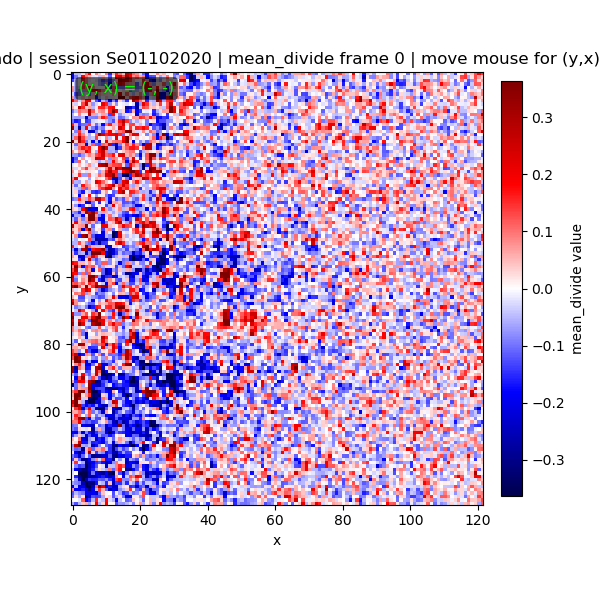

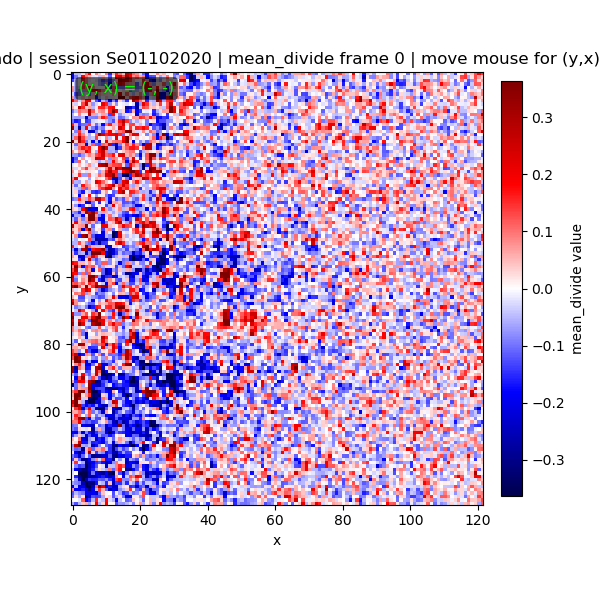

In [8]:
USE_WIDGET = True  # set False to force static inline plot

ipy = get_ipython()
backend_mode = "inline"

if ipy is not None and USE_WIDGET:
    try:
        ipy.run_line_magic('matplotlib', 'widget')
        backend_mode = "widget"
    except Exception as e:
        print(f"Could not enable interactive matplotlib backend ({e}); falling back to inline.")
        try:
            ipy.run_line_magic('matplotlib', 'inline')
        except Exception:
            pass
else:
    if ipy is not None:
        try:
            ipy.run_line_magic('matplotlib', 'inline')
        except Exception:
            pass

print(f"Matplotlib backend: {matplotlib.get_backend()} | mode={backend_mode}")

subjects = ["secundo", "gus"]
sample_subject = subjects[0]  # change if needed
sample_session_idx = 2        # change if needed
sample_frame_idx = 0          # change if needed

baseline_output_dir = (deriv_root / sample_subject / "baseline_only")
baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

if len(baseline_sessions) == 0:
    raise RuntimeError(f"No baseline sessions found for {sample_subject}")

sample_session = baseline_sessions[sample_session_idx]
raw_frames = sample_session["frames"].astype(np.float32, copy=False)
mean_frames = hf.normalize_frames_pixelwise(raw_frames, method="mean_divide")

if not (0 <= sample_frame_idx < mean_frames.shape[0]):
    raise ValueError(f"sample_frame_idx={sample_frame_idx} out of range [0, {mean_frames.shape[0]-1}]")

frame = mean_frames[sample_frame_idx]

# symmetric limits around 0 for diverging display
abs_lim = float(np.percentile(np.abs(frame), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(frame, cmap='seismic', norm=norm)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('mean_divide value', rotation=90)
ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} | mean_divide frame {sample_frame_idx} | move mouse for (y,x)"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

coord_text = ax.text(
    0.02, 0.98, "(y, x) = (-, -)",
    transform=ax.transAxes,
    ha='left', va='top',
    fontsize=11,
    color='lime',
    bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.25')
)


def on_move(event):
    if event.inaxes != ax or event.xdata is None or event.ydata is None:
        return
    x = int(round(event.xdata))
    y = int(round(event.ydata))
    h, w = frame.shape
    if 0 <= x < w and 0 <= y < h:
        coord_text.set_text(f"(y, x) = ({y}, {x})")
        fig.canvas.draw_idle()


# show coordinates in status/toolbar when supported
ax.format_coord = lambda x, y: f"x={int(round(x))}, y={int(round(y))}" if (x is not None and y is not None) else ""

_ = fig.canvas.mpl_connect('motion_notify_event', on_move)
plt.tight_layout()
explorer_fig = fig

# explicit display path for reliability across frontends
if backend_mode == "widget":
    display(fig.canvas)
else:
    display(fig)
    plt.show()




whole frame timecourse with red/ blue colour map 

In [ ]:
ref_frame = mean_frames[sample_frame_idx]
abs_lim = float(np.percentile(np.abs(ref_frame), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(mean_frames[0], cmap="seismic", norm=norm)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mean_divide value", rotation=90)

title = ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} | mean_divide frame 0"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

T = mean_frames.shape[0]

def update(i):
    im.set_data(mean_frames[i])
    title.set_text(
        f"{sample_subject} | session {sample_session['session_id']} | mean_divide frame {i}"
    )
    return (im,)

ani = animation.FuncAnimation(fig, update, frames=T, interval=100, blit=False, repeat=False)

out_dir = Path("html_outputs") / "videos"
out_dir.mkdir(parents=True, exist_ok=True)
base = f"{sample_subject}_session-{sample_session['session_id']}_mean_divide"

mp4_path = out_dir / f"{base}.mp4"
gif_path = out_dir / f"{base}.gif"

saved = None
try:
    writer = animation.FFMpegWriter(fps=10, bitrate=1800)
    ani.save(str(mp4_path), writer=writer, dpi=150)
    saved = mp4_path
except FileNotFoundError:
    print("ffmpeg not found; saving GIF instead...")
    writer = animation.PillowWriter(fps=10)
    ani.save(str(gif_path), writer=writer, dpi=120)
    saved = gif_path

plt.close(fig)
print(f"Saved: {saved}")



Saved: html_outputs\videos\secundo_session-Se01102020_mean_divide.mp4


✅ Loaded 34 baseline sessions


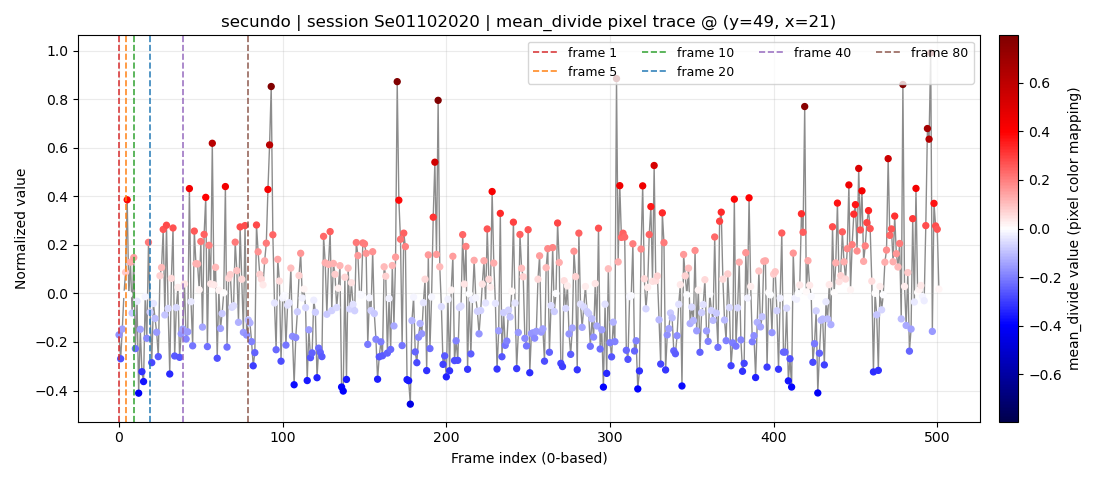

In [9]:
# plot one pixel over time (mean_divide normalization) for a sample baseline acquisition
# with color-mapped values + colorbar

from matplotlib.colors import TwoSlopeNorm

sample_subject = subjects[0]  # change if needed
sample_session_idx = 2        # change if needed

baseline_output_dir = (deriv_root / sample_subject / "baseline_only")
baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

if len(baseline_sessions) == 0:
    raise RuntimeError(f"No baseline sessions found for {sample_subject}")

sample_session = baseline_sessions[sample_session_idx]
raw_frames = sample_session["frames"].astype(np.float32, copy=False)  # (T,H,W)
mean_frames = hf.normalize_frames_pixelwise(raw_frames, method="mean_divide")

T, H, W = mean_frames.shape
y = 49
x = 21  # slightly left of center

pixel_ts = mean_frames[:, y, x]
t = np.arange(T)

# symmetric color limits around 0 from robust percentile of this pixel trace
abs_lim = float(np.percentile(np.abs(pixel_ts), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(11, 4.8))
ax.plot(t, pixel_ts, color='black', linewidth=1.0, alpha=0.45, zorder=1)
sc = ax.scatter(t, pixel_ts, c=pixel_ts, cmap='seismic', norm=norm, s=18, zorder=2)

marker_frames_1based = [1, 5, 10, 20, 40, 80]
marker_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:brown']

for f, c in zip(marker_frames_1based, marker_colors):
    idxf = f - 1  # convert to 0-based index for plotting
    if 0 <= idxf < T:
        ax.axvline(idxf, linestyle='--', linewidth=1.2, color=c, alpha=0.9, label=f'frame {f}')

cbar = fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label('mean_divide value (pixel color mapping)', rotation=90)

ax.set_title(f"{sample_subject} | session {sample_session['session_id']} | mean_divide pixel trace @ (y={y}, x={x})")
ax.set_xlabel("Frame index (0-based)")
ax.set_ylabel("Normalized value")
ax.grid(alpha=0.25)
ax.legend(ncol=4, fontsize=9)
fig.tight_layout()
pixel_trace_fig = fig
plt.show()




#### a patch of pixels 

In [13]:
# load data + set up for plotting multiple pixels around a given pixel
from matplotlib.colors import TwoSlopeNorm

sample_subject = subjects[0]
sample_session_idx = 2        

baseline_output_dir = (deriv_root / sample_subject / "baseline_only")
baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

if len(baseline_sessions) == 0:
    raise RuntimeError(f"No baseline sessions found for {sample_subject}")

sample_session = baseline_sessions[sample_session_idx]
raw_frames = sample_session["frames"].astype(np.float32, copy=False)  # (T,H,W)
mean_frames = hf.normalize_frames_pixelwise(raw_frames, method="mean_divide")

T, H, W = mean_frames.shape
pixel = (49, 21) 
center_pixel = pixel
radius = 1

y0 = max(0, pixel[0] - radius)
x0 = max(0, pixel[1] - radius)
y1 = min(H, pixel[0] + radius+1)
x1 = min(W, pixel[1] + radius+1)
y_range = range(y0 - pixel[0], y1 - pixel[0])
x_range = range(x0 - pixel[1], x1 - pixel[1])

surrounding_pixels = [(pixel[0] + dy, pixel[1] + dx) for dy in y_range for dx in x_range if (dy, dx) != (0, 0)]

pixel_coordinates = sorted(surrounding_pixels + [pixel])
print(f"Plotting {len(pixel_coordinates)} pixels around (y={pixel[0]}, x={pixel[1]})")
pixel_trace_colours = [f"C{i}" for i in range(len(pixel_coordinates))]
coord_to_color = {p: pixel_trace_colours[i] for i, p in enumerate(pixel_coordinates)}

✅ Loaded 34 baseline sessions
Plotting 9 pixels around (y=49, x=21)


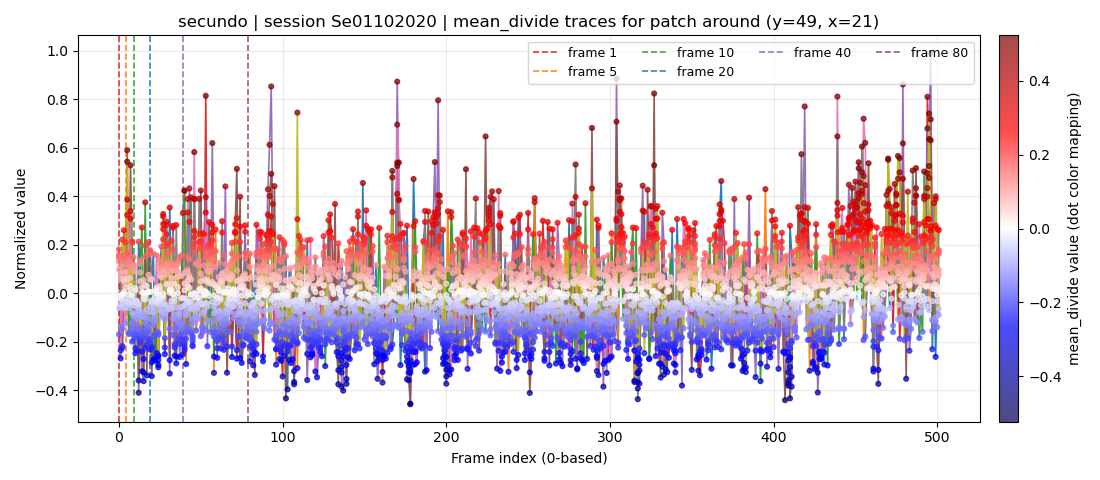

In [14]:
# plot multile pixels over time (mean_divide normalization) for a sample baseline acquisition

all_patch_values = np.concatenate([mean_frames[:, y, x] for (y, x) in pixel_coordinates])
abs_lim = float(np.nanpercentile(np.abs(all_patch_values), 99.0))
if not np.isfinite(abs_lim) or abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(11, 4.8))
for pixel in pixel_coordinates:
    y, x = pixel
    pixel_ts = mean_frames[:, y, x]
    t = np.arange(T)

    trace_color = coord_to_color[pixel]
    ax.plot(t, pixel_ts, color=trace_color, linewidth=1.2, alpha=0.95, zorder=2)
    sc = ax.scatter(t, pixel_ts, c=pixel_ts, cmap='seismic', norm=norm, s=12, alpha=0.70, zorder=3)

marker_frames_1based = [1, 5, 10, 20, 40, 80]
marker_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:brown']

for f, c in zip(marker_frames_1based, marker_colors):
    idxf = f - 1  # convert to 0-based index for plotting
    if 0 <= idxf < T:
        ax.axvline(idxf, linestyle='--', linewidth=1.2, color=c, alpha=0.9, label=f'frame {f}')

cbar = fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label('mean_divide value (dot color mapping)', rotation=90)

ax.set_title(f"{sample_subject} | session {sample_session['session_id']} | mean_divide traces for patch around (y={center_pixel[0]}, x={center_pixel[1]})")
ax.set_xlabel("Frame index (0-based)")
ax.set_ylabel("Normalized value")
ax.grid(alpha=0.25)
ax.legend(ncol=4, fontsize=9)
fig.tight_layout()
# pixel_trace_fig = fig
plt.show()

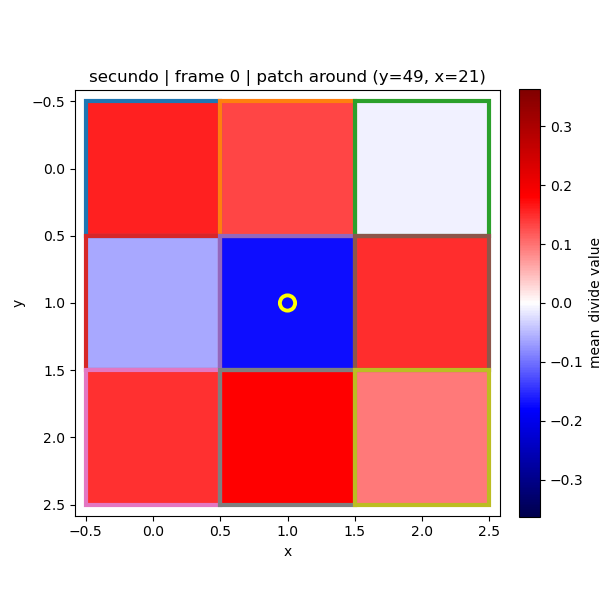

In [15]:
# center pixel as (y, x)
center_pixel = (49, 21)
cy, cx = center_pixel
r = 1  # 3x3 patch
sample_frame_idx=0
frame = mean_frames[sample_frame_idx]  
H, W = frame.shape

# patch bounds
y0, y1 = max(0, cy - r), min(H, cy + r + 1)
x0, x1 = max(0, cx - r), min(W, cx + r + 1)
patch = frame[y0:y1, x0:x1]
h, w = patch.shape

abs_lim = float(np.nanpercentile(np.abs(frame), 99.0))
if not np.isfinite(abs_lim) or abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(patch, cmap="seismic", norm=norm, interpolation="nearest")
pad = 0.08  # small axis buffer so outer borders are visible
ax.set_xlim(-0.5 - pad, w - 0.5 + pad)
ax.set_ylim(h - 0.5 + pad, -0.5 - pad) 

# thicker per-pixel outlines, colored to match trace colors
for iy in range(h):
    for ix in range(w):
        global_coord = (y0 + iy, x0 + ix)  # (y, x) in full frame
        edge = coord_to_color.get(global_coord, "white")
        ax.add_patch(Rectangle((ix - 0.5, iy - 0.5), 1, 1,
                               fill=False, edgecolor=edge, linewidth=3.0))

ax.scatter(cx - x0, cy - y0, s=120, facecolors="none",
           edgecolors="yellow", linewidths=2.8, zorder=5)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mean_divide value", rotation=90)

ax.set_title(f"{sample_subject} | frame {sample_frame_idx} | patch around (y={cy}, x={cx})")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
plt.show()



video of patch time course with red/blue colour map

In [17]:
# center pixel as (y, x)
center_pixel = (49, 21)
cy, cx = center_pixel
r = 1  # 3x3 patch

# patch bounds
y0, y1 = max(0, cy - r), min(H, cy + r + 1)
x0, x1 = max(0, cx - r), min(W, cx + r + 1)
patch = frame[y0:y1, x0:x1]
h, w = patch.shape

patched_frames = mean_frames[:, y0:y1, x0:x1]  # (T, h, w)

sample_frame_idx=0
frame = mean_frames[sample_frame_idx]  
H, W = frame.shape

ref_frame = mean_frames[sample_frame_idx]
abs_lim = float(np.percentile(np.abs(ref_frame), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)



fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(patch, cmap="seismic", norm=norm)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mean_divide value", rotation=90)

title = ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} |patch | mean_divide frame 0"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

T = patched_frames.shape[0]

def update(i):
    im.set_data(patched_frames[i])
    title.set_text(
        f"{sample_subject} | session {sample_session['session_id']} | mean_divide frame {i}"
    )
    return (im,)

ani = animation.FuncAnimation(fig, update, frames=T, interval=100, blit=False, repeat=False)

out_dir = Path("html_outputs") / "videos"
out_dir.mkdir(parents=True, exist_ok=True)
base = f"{sample_subject}_session-{sample_session['session_id']}_mean_divide_patch"

mp4_path = out_dir / f"{base}.mp4"
gif_path = out_dir / f"{base}.gif"

saved = None
try:
    writer = animation.FFMpegWriter(fps=10, bitrate=1800)
    ani.save(str(mp4_path), writer=writer, dpi=150)
    saved = mp4_path
except FileNotFoundError:
    print("ffmpeg not found; saving GIF instead...")
    writer = animation.PillowWriter(fps=10)
    ani.save(str(gif_path), writer=writer, dpi=120)
    saved = gif_path

plt.close(fig)
print(f"Saved: {saved}")



Saved: html_outputs\videos\secundo_session-Se01102020_mean_divide_patch.mp4


## Exploratory data analysis
### 1. Distribution etc..
will display just a sample acquisition, but will save plots for each acquisition
#### Histograms of intensities
per acquisiton 

In [14]:
sample_subject = subjects[0]
sample_session_idx = 2

DIST_N_BINS = 120
DIST_MAX_POINTS = 500_000  # random subsample for speed in histogram ops
DIST_MODE_ORDER = ["mean_divide", "zscore"]
DIST_MODE_RANGES = {
    # "raw": None,                # computed per subject from robust percentiles
    "mean_divide": (-0.25, 0.25),
    "zscore": (-3.0, 3.0),
}

EDA_ROOT_NAME = "eda"


✅ Loaded 34 baseline sessions

[secundo] per-acquisition histograms | sessions=34


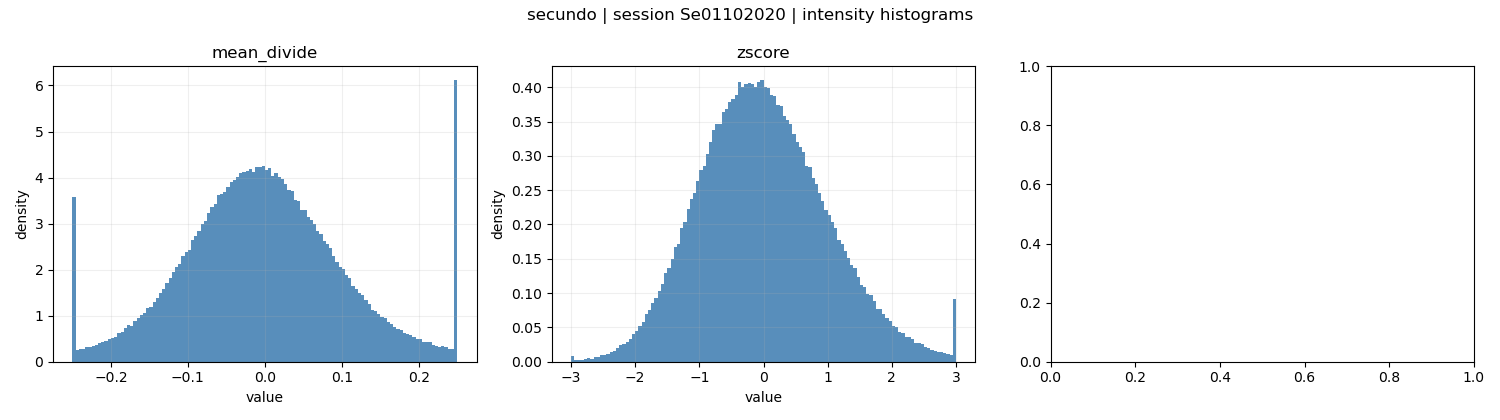

Saved per-acquisition histograms to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\distribution\hist_per_acquisition
✅ Loaded 13 baseline sessions

[gus] per-acquisition histograms | sessions=13
Saved per-acquisition histograms to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\distribution\hist_per_acquisition


In [15]:


def _eda_subject_root(subject):
    root = deriv_root / subject / EDA_ROOT_NAME / "distribution"
    root.mkdir(parents=True, exist_ok=True)
    return root


def _mode_transform(frames, mode):
    if mode == "raw":
        return frames.astype(np.float32, copy=False)
    return hf.normalize_frames_pixelwise(frames, method=mode)


def _flatten_for_hist(arr, max_points=DIST_MAX_POINTS, seed=42):
    v = arr.reshape(-1)
    n = v.size
    if n <= max_points:
        return v
    rng = np.random.default_rng(seed)
    idx = rng.choice(n, size=max_points, replace=False)
    return v[idx]


def _subject_raw_range(baseline_sessions, q_low=1.0, q_high=99.0):
    lows, highs = [], []
    for sess in baseline_sessions:
        f = sess["frames"].astype(np.float32, copy=False)
        lows.append(float(np.percentile(f, q_low)))
        highs.append(float(np.percentile(f, q_high)))
    lo = float(np.median(lows)) if len(lows) else 0.0
    hi = float(np.median(highs)) if len(highs) else 1.0
    if hi <= lo:
        hi = lo + 1e-6
    return lo, hi


for subject in subjects:
    subject_root = _eda_subject_root(subject)
    out_dir = subject_root / "hist_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    baseline_output_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}; skipping per-acquisition histograms")
        continue

    # subject-specific robust range for raw
    raw_lo, raw_hi = _subject_raw_range(baseline_sessions)
    mode_ranges = dict(DIST_MODE_RANGES)
    mode_ranges["raw"] = (raw_lo, raw_hi)

    print(f"\n[{subject}] per-acquisition histograms | sessions={len(baseline_sessions)}")

    for s_idx, sess in enumerate(baseline_sessions):
        session_id = sess["session_id"]
        raw = sess["frames"].astype(np.float32, copy=False)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))

        for ax, mode in zip(axes, DIST_MODE_ORDER):
            arr = _mode_transform(raw, mode)
            vals = _flatten_for_hist(arr, max_points=DIST_MAX_POINTS, seed=42 + s_idx)

            lo, hi = mode_ranges[mode]
            vals_plot = np.clip(vals, lo, hi)

            ax.hist(vals_plot, bins=DIST_N_BINS, range=(lo, hi), density=True, alpha=0.9, color="steelblue")
            ax.set_title(mode)
            ax.set_xlabel("value")
            ax.set_ylabel("density")
            ax.grid(alpha=0.2)

        fig.suptitle(f"{subject} | session {session_id} | intensity histograms")
        fig.tight_layout()

        out_path = out_dir / f"{subject}_{session_id}_hist_triplet.png"
        fig.savefig(out_path, dpi=180)

        if subject == sample_subject and s_idx == sample_session_idx:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved per-acquisition histograms to: {out_dir}")


#### mean/median/max intensity values over time
per acquisition

✅ Loaded 34 baseline sessions

[secundo] per-acquisition time stats | sessions=34


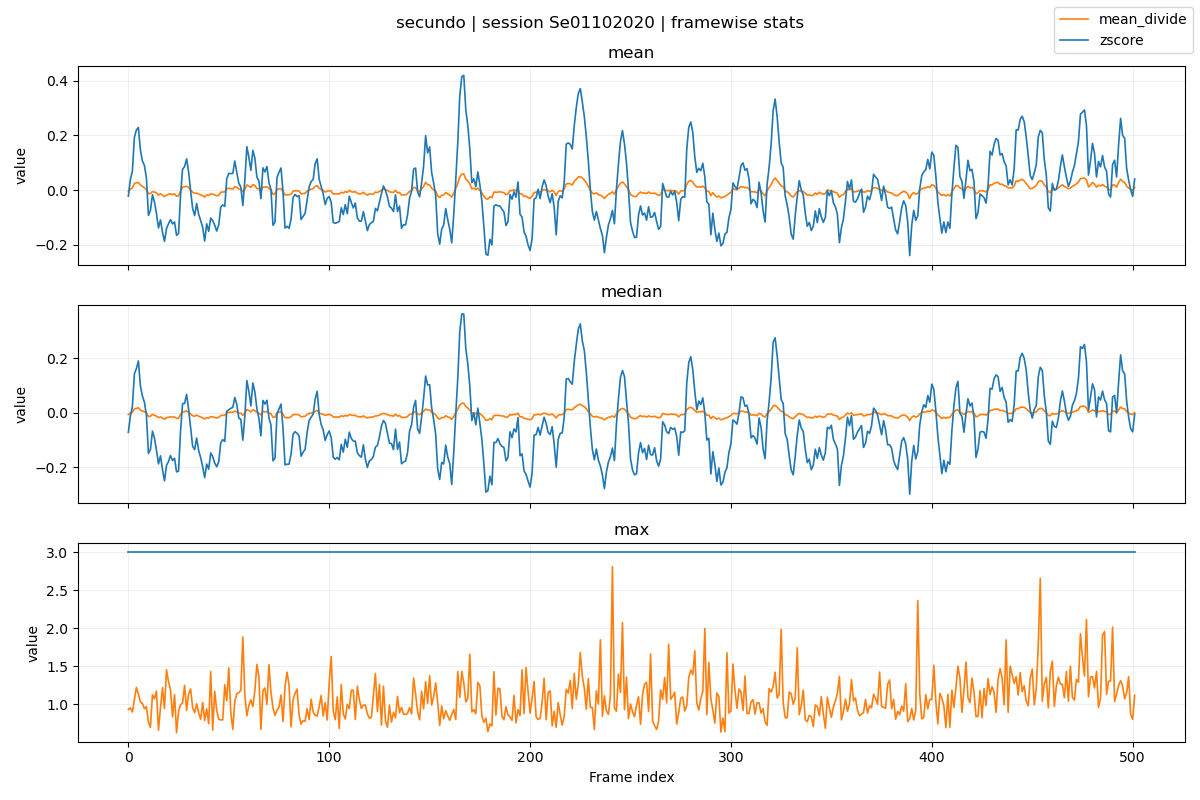

KeyboardInterrupt: 

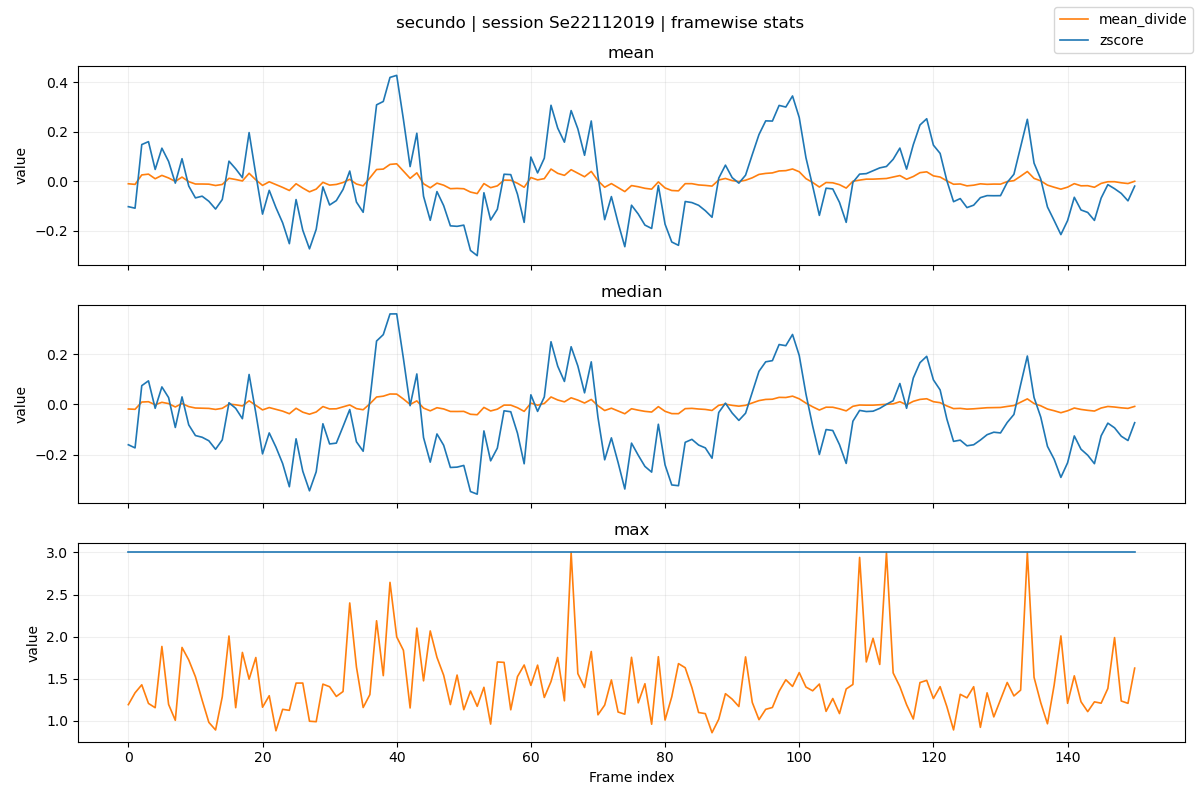

In [16]:
for subject in subjects:
    subject_root = _eda_subject_root(subject)
    out_dir = subject_root / "time_stats_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    baseline_output_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}; skipping per-acquisition time stats")
        continue

    print(f"\n[{subject}] per-acquisition time stats | sessions={len(baseline_sessions)}")

    for s_idx, sess in enumerate(baseline_sessions):
        session_id = sess["session_id"]
        raw = sess["frames"].astype(np.float32, copy=False)

        stats = {}
        for mode in DIST_MODE_ORDER:
            arr = _mode_transform(raw, mode)  # (T,H,W)
            stats[mode] = {
                "mean": arr.mean(axis=(1, 2)),
                "median": np.median(arr, axis=(1, 2)),
                "max": arr.max(axis=(1, 2)),
            }

        t = np.arange(raw.shape[0])
        metrics = ["mean", "median", "max"]
        colors = {"mean_divide": "tab:orange", "zscore": "tab:blue"}

        fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
        for ax, metric in zip(axes, metrics):
            for mode in DIST_MODE_ORDER:
                ax.plot(t, stats[mode][metric], color=colors[mode], linewidth=1.2, label=mode)
            ax.set_title(metric)
            ax.grid(alpha=0.2)
            ax.set_ylabel("value")

        axes[-1].set_xlabel("Frame index")
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right")
        fig.suptitle(f"{subject} | session {session_id} | framewise stats")
        fig.tight_layout()

        out_fig = out_dir / f"{subject}_{session_id}_time_stats_triplet.png"
        fig.savefig(out_fig, dpi=180)

        # save table
        rows = []
        for mode in DIST_MODE_ORDER:
            for i in range(len(t)):
                rows.append({
                    "frame": int(i),
                    "mode": mode,
                    "mean": float(stats[mode]["mean"][i]),
                    "median": float(stats[mode]["median"][i]),
                    "max": float(stats[mode]["max"][i]),
                })
        pd.DataFrame(rows).to_csv(out_dir / f"{subject}_{session_id}_time_stats_triplet.csv", index=False)

        if subject == sample_subject and s_idx == sample_session_idx:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved per-acquisition time stats to: {out_dir}")


across acquisitions

In [ ]:
# N_NORM_T = 200


# def _resample_to_unit_time(v, n=N_NORM_T):
#     v = np.asarray(v, dtype=np.float32)
#     if v.size <= 1:
#         return np.full((n,), float(v[0]) if v.size == 1 else np.nan, dtype=np.float32)
#     x_old = np.linspace(0.0, 1.0, v.size)
#     x_new = np.linspace(0.0, 1.0, n)
#     return np.interp(x_new, x_old, v).astype(np.float32)


# for subject in subjects:
#     subject_root = _eda_subject_root(subject)
#     out_dir = subject_root / "time_stats_across_acquisitions"
#     out_dir.mkdir(parents=True, exist_ok=True)

#     baseline_output_dir = deriv_root / subject / "baseline_only"
#     baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

#     if len(baseline_sessions) == 0:
#         print(f"No baseline sessions for {subject}; skipping across-acquisition time stats")
#         continue

#     metrics = ["mean", "median", "max"]

#     # collect resampled series: metric -> mode -> list of (N_NORM_T,)
#     collect = {m: {mode: [] for mode in DIST_MODE_ORDER} for m in metrics}

#     for sess in baseline_sessions:
#         raw = sess["frames"].astype(np.float32, copy=False)
#         for mode in DIST_MODE_ORDER:
#             arr = _mode_transform(raw, mode)
#             series = {
#                 "mean": arr.mean(axis=(1, 2)),
#                 "median": np.median(arr, axis=(1, 2)),
#                 "max": arr.max(axis=(1, 2)),
#             }
#             for m in metrics:
#                 collect[m][mode].append(_resample_to_unit_time(series[m], n=N_NORM_T))

#     # aggregate + plot
#     x = np.linspace(0.0, 1.0, N_NORM_T)
#     colors = {"raw": "black", "mean_divide": "tab:orange", "zscore": "tab:blue"}

#     fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
#     table_rows = []

#     for ax, m in zip(axes, metrics):
#         for mode in DIST_MODE_ORDER:
#             S = np.stack(collect[m][mode], axis=0)  # (n_sessions, N_NORM_T)
#             mu = S.mean(axis=0)
#             sd = S.std(axis=0)

#             ax.plot(x, mu, color=colors[mode], linewidth=1.4, label=mode)
#             ax.fill_between(x, mu - sd, mu + sd, color=colors[mode], alpha=0.20)

#             for i in range(N_NORM_T):
#                 table_rows.append({
#                     "metric": m,
#                     "mode": mode,
#                     "norm_time": float(x[i]),
#                     "mean": float(mu[i]),
#                     "std": float(sd[i]),
#                 })

#         ax.set_title(m)
#         ax.grid(alpha=0.2)
#         ax.set_ylabel("value")

#     axes[-1].set_xlabel("Normalized time (0..1)")
#     handles, labels = axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc="upper right")
#     fig.suptitle(f"{subject} | time-stat summary across acquisitions (n={len(baseline_sessions)})")
#     fig.tight_layout()

#     out_fig = out_dir / f"{subject}_time_stats_across_acquisitions.png"
#     fig.savefig(out_fig, dpi=180)
#     pd.DataFrame(table_rows).to_csv(out_dir / f"{subject}_time_stats_across_acquisitions_table.csv", index=False)

#     if subject == sample_subject:
#         plt.show()
#     else:
#         plt.close(fig)

#     print(f"Saved across-acquisition time stats to: {out_dir}")


### 2. Pixel stability
will display just a sample acquisition, but will save plots for each acquisition
#### Mean map + std map
per acquisition

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PIX_MODE_ORDER = list(DIST_MODE_ORDER) if "DIST_MODE_ORDER" in globals() else ["mean_divide", "zscore"]
PIX_EPS = 1e-8
PIX_ROBUST_PCTL = (1.0, 99.0)
PIX_CV_CLIP = 5.0
PIX_ROOT_SUBDIR = "pixel_stability"

def _pix_mode_transform(frames, mode):
    if "_mode_transform" in globals() and callable(_mode_transform):
        return _mode_transform(frames, mode)
    if mode == "raw":
        return frames
    return hf.normalize_frames_pixelwise(frames, method=mode)

def _pix_subject_root(subject):
    return deriv_root / subject / EDA_ROOT_NAME / PIX_ROOT_SUBDIR

def _pix_finite(a):
    return a[np.isfinite(a)]

def _pix_stats(a):
    x = _pix_finite(a)
    if x.size == 0:
        return dict(min=np.nan, max=np.nan, mean=np.nan, median=np.nan)
    return dict(min=float(np.min(x)), max=float(np.max(x)), mean=float(np.mean(x)), median=float(np.median(x)))

def _pix_limits(a, pctl=PIX_ROBUST_PCTL, nonnegative=False, symmetric=False):
    x = _pix_finite(a)
    if x.size == 0:
        return (0.0, 1.0)
    lo, hi = np.percentile(x, pctl)
    lo = float(lo)
    hi = float(hi)
    if symmetric:
        m = max(abs(lo), abs(hi), PIX_EPS)
        return (-m, m)
    if nonnegative:
        lo = max(0.0, lo)
    if hi <= lo + PIX_EPS:
        hi = lo + 1.0
    return (lo, hi)

for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(f"\\n[{subject}] pixel stability mean/std per acquisition | sessions={len(baseline_sessions)}")
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "mean_std_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    for s_idx, session in enumerate(baseline_sessions):
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode)
            mu_map = arr.mean(axis=0)
            sd_map = arr.std(axis=0)

            both_signs = (np.nanmin(mu_map) < 0.0) and (np.nanmax(mu_map) > 0.0)
            use_diverging = (mode == "mean_divide") or both_signs
            if use_diverging:
                mu_vmin, mu_vmax = _pix_limits(mu_map, symmetric=True)
                mu_cmap = "seismic"
            else:
                mu_vmin, mu_vmax = _pix_limits(mu_map)
                mu_cmap = "viridis"

            sd_vmin, sd_vmax = _pix_limits(sd_map, nonnegative=True)

            fig, axes = plt.subplots(1, 2, figsize=(11, 4.8))
            im0 = axes[0].imshow(mu_map, cmap=mu_cmap, vmin=mu_vmin, vmax=mu_vmax)
            axes[0].set_title(f"{subject} | {session_id} | {mode} | temporal mean map")
            axes[0].set_xlabel("x")
            axes[0].set_ylabel("y")
            fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

            im1 = axes[1].imshow(sd_map, cmap="viridis", vmin=sd_vmin, vmax=sd_vmax)
            axes[1].set_title(f"{subject} | {session_id} | {mode} | temporal std map")
            axes[1].set_xlabel("x")
            axes[1].set_ylabel("y")
            fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

            fig.tight_layout()
            out_fig = out_dir / f"{subject}_{session_id}_{mode}_mean_std_maps.png"
            fig.savefig(out_fig, dpi=180)

            rows = []
            for map_name, stats in [("mean_map", _pix_stats(mu_map)), ("std_map", _pix_stats(sd_map))]:
                rows.append({
                    "subject": subject,
                    "session_id": session_id,
                    "mode": mode,
                    "map": map_name,
                    "min": stats["min"],
                    "max": stats["max"],
                    "mean": stats["mean"],
                    "median": stats["median"],
                })
            pd.DataFrame(rows).to_csv(
                out_dir / f"{subject}_{session_id}_{mode}_mean_std_maps_summary.csv",
                index=False,
            )

            if subject == sample_subject and s_idx == sample_session_idx:
                plt.show()
            else:
                plt.close(fig)

    print(f"Saved per-acquisition mean/std maps to: {out_dir}")


across acquisitions

In [ ]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(f"\\n[{subject}] pixel stability mean/std across acquisitions | sessions={len(baseline_sessions)}")
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "mean_std_across_acquisitions"
    out_dir.mkdir(parents=True, exist_ok=True)

    mode_collect = {mode: {"mu": [], "sd": []} for mode in PIX_MODE_ORDER}
    ref_shape = None

    for session in baseline_sessions:
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)
        shp = raw.shape[1:]
        if ref_shape is None:
            ref_shape = shp
        elif shp != ref_shape:
            print(f"  - skip {session_id}: shape {shp} != {ref_shape}")
            continue

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode)
            mode_collect[mode]["mu"].append(arr.mean(axis=0))
            mode_collect[mode]["sd"].append(arr.std(axis=0))

    for mode in PIX_MODE_ORDER:
        if len(mode_collect[mode]["mu"]) == 0:
            print(f"  - skip mode={mode}: no valid sessions")
            continue

        MU = np.stack(mode_collect[mode]["mu"], axis=0)
        SD = np.stack(mode_collect[mode]["sd"], axis=0)

        mu_across_mean = MU.mean(axis=0)
        mu_across_std = MU.std(axis=0)
        sd_across_mean = SD.mean(axis=0)
        sd_across_std = SD.std(axis=0)

        fig, axes = plt.subplots(2, 2, figsize=(11, 9))
        panels = [
            (mu_across_mean, "seismic" if mode == "mean_divide" else "viridis", f"{subject} | {mode} | across-acq mean of temporal mean", False),
            (mu_across_std, "viridis", f"{subject} | {mode} | across-acq std of temporal mean", True),
            (sd_across_mean, "viridis", f"{subject} | {mode} | across-acq mean of temporal std", True),
            (sd_across_std, "viridis", f"{subject} | {mode} | across-acq std of temporal std", True),
        ]

        for ax, (data, cmap, title, nonneg) in zip(axes.ravel(), panels):
            if cmap == "seismic":
                vmin, vmax = _pix_limits(data, symmetric=True)
            else:
                vmin, vmax = _pix_limits(data, nonnegative=nonneg)
            im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
            ax.set_title(title)
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        fig.tight_layout()
        out_fig = out_dir / f"{subject}_{mode}_mean_std_across_acquisitions_maps.png"
        fig.savefig(out_fig, dpi=180)

        rows = []
        for map_name, data in [
            ("mu_across_mean", mu_across_mean),
            ("mu_across_std", mu_across_std),
            ("sd_across_mean", sd_across_mean),
            ("sd_across_std", sd_across_std),
        ]:
            st = _pix_stats(data)
            rows.append({
                "subject": subject,
                "mode": mode,
                "map": map_name,
                "n_sessions": int(MU.shape[0]),
                "min": st["min"],
                "max": st["max"],
                "mean": st["mean"],
                "median": st["median"],
            })
        pd.DataFrame(rows).to_csv(
            out_dir / f"{subject}_{mode}_mean_std_across_acquisitions_summary.csv",
            index=False,
        )

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved across-acquisition mean/std maps to: {out_dir}")


####  CV map
per acquisition

In [ ]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(f"\\n[{subject}] pixel stability CV per acquisition | sessions={len(baseline_sessions)}")
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "cv_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    for s_idx, session in enumerate(baseline_sessions):
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode)
            mu_map = arr.mean(axis=0)
            sd_map = arr.std(axis=0)
            cv_map = sd_map / (np.abs(mu_map) + PIX_EPS)
            cv_map = np.where(np.isfinite(cv_map), cv_map, np.nan)

            cv_disp = np.clip(cv_map, 0.0, PIX_CV_CLIP)
            cv_vmin, cv_vmax = _pix_limits(cv_disp, nonnegative=True)

            fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.8))
            im = ax.imshow(cv_disp, cmap="magma", vmin=cv_vmin, vmax=cv_vmax)
            ax.set_title(f"{subject} | {session_id} | {mode} | temporal CV map")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="CV (clipped for display)")
            fig.tight_layout()

            out_fig = out_dir / f"{subject}_{session_id}_{mode}_cv_map.png"
            fig.savefig(out_fig, dpi=180)

            st = _pix_stats(cv_map)
            pd.DataFrame([
                {
                    "subject": subject,
                    "session_id": session_id,
                    "mode": mode,
                    "map": "cv_map",
                    "eps": PIX_EPS,
                    "clip_for_display": PIX_CV_CLIP,
                    "min": st["min"],
                    "max": st["max"],
                    "mean": st["mean"],
                    "median": st["median"],
                }
            ]).to_csv(out_dir / f"{subject}_{session_id}_{mode}_cv_map_summary.csv", index=False)

            if subject == sample_subject and s_idx == sample_session_idx:
                plt.show()
            else:
                plt.close(fig)

    print(f"Saved per-acquisition CV maps to: {out_dir}")


across acquisitions

In [ ]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(f"\\n[{subject}] pixel stability CV across acquisitions | sessions={len(baseline_sessions)}")
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "cv_across_acquisitions"
    out_dir.mkdir(parents=True, exist_ok=True)

    mode_collect = {mode: [] for mode in PIX_MODE_ORDER}
    ref_shape = None

    for session in baseline_sessions:
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)
        shp = raw.shape[1:]
        if ref_shape is None:
            ref_shape = shp
        elif shp != ref_shape:
            print(f"  - skip {session_id}: shape {shp} != {ref_shape}")
            continue

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode)
            mu_map = arr.mean(axis=0)
            sd_map = arr.std(axis=0)
            cv_map = sd_map / (np.abs(mu_map) + PIX_EPS)
            cv_map = np.where(np.isfinite(cv_map), cv_map, np.nan)
            mode_collect[mode].append(cv_map)

    for mode in PIX_MODE_ORDER:
        if len(mode_collect[mode]) == 0:
            print(f"  - skip mode={mode}: no valid sessions")
            continue

        CV = np.stack(mode_collect[mode], axis=0)
        cv_across_mean = np.nanmean(CV, axis=0)
        cv_across_std = np.nanstd(CV, axis=0)

        mean_disp = np.clip(cv_across_mean, 0.0, PIX_CV_CLIP)
        mean_vmin, mean_vmax = _pix_limits(mean_disp, nonnegative=True)
        std_vmin, std_vmax = _pix_limits(cv_across_std, nonnegative=True)

        fig, axes = plt.subplots(1, 2, figsize=(11, 4.8))
        im0 = axes[0].imshow(mean_disp, cmap="magma", vmin=mean_vmin, vmax=mean_vmax)
        axes[0].set_title(f"{subject} | {mode} | across-acq mean CV")
        axes[0].set_xlabel("x")
        axes[0].set_ylabel("y")
        fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

        im1 = axes[1].imshow(cv_across_std, cmap="viridis", vmin=std_vmin, vmax=std_vmax)
        axes[1].set_title(f"{subject} | {mode} | across-acq std of CV")
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("y")
        fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        fig.tight_layout()
        out_fig = out_dir / f"{subject}_{mode}_cv_across_acquisitions_maps.png"
        fig.savefig(out_fig, dpi=180)

        rows = []
        for map_name, data in [
            ("cv_across_mean", cv_across_mean),
            ("cv_across_std", cv_across_std),
        ]:
            st = _pix_stats(data)
            rows.append({
                "subject": subject,
                "mode": mode,
                "map": map_name,
                "n_sessions": int(CV.shape[0]),
                "eps": PIX_EPS,
                "clip_for_display": PIX_CV_CLIP,
                "min": st["min"],
                "max": st["max"],
                "mean": st["mean"],
                "median": st["median"],
            })
        pd.DataFrame(rows).to_csv(
            out_dir / f"{subject}_{mode}_cv_across_acquisitions_summary.csv",
            index=False,
        )

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved across-acquisition CV maps to: {out_dir}")


### 3. Frame to frame difference
per acquisition

across acquisitions

### 4. Spatial-temporal dist
#### Autocorrelation 

#### PSDs
per acquisition 

across acquisitions